# Probabilistic Programming - 3
## Monte Carlo sampling

In this notebook, we will be looking at forecasting a time-series. To be precise, we will implement a Hidden Markov Model using Turing.

### Preliminaries

- Goal 
  - Learn to apply Turing to a time-series data set.
- Materials        
  - Mandatory
    - These lecture notes.
  - Optional
    - Tutorial on HMM using [Turing.jl](https://turing.ml/dev/tutorials/4-bayeshmm/)
    - Cheatsheets: [how does Julia differ from Matlab / Python](https://docs.julialang.org/en/v1/manual/noteworthy-differences/index.html).

In [30]:
using Random
using Distributions
using Plots
pyplot()
include("../scripts/pp-3.jl") 

Random.seed!(1234);

### Generate data

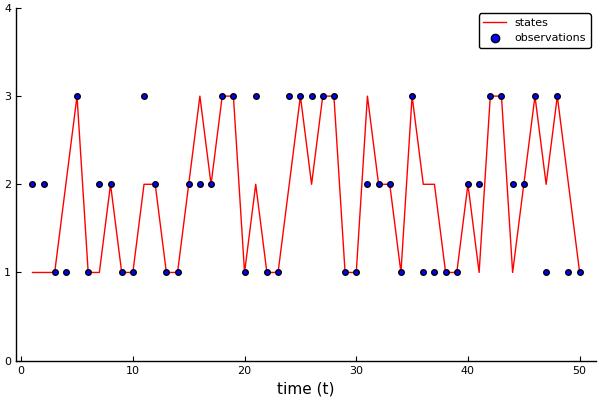

In [23]:
# There are 3 possible states and each variable is in one of those (one-hot encoding)
K = 3

# Length of time-series
T = 50

# Transition matrix of latent variables
transition = [0.3 0.6 0.1; 
              0.5 0.2 0.3; 
              0.2 0.8 0.1]

# Emission matrix for observed variables
emission = [0.7 0.3 0.0; 
            0.2 0.6 0.2; 
            0.0 0.3 0.7]

# Preallocate data arrays
X = zeros(T+1, K)
Y = zeros(T, K)

# Initial state
X[1,:] = [0.0, 1.0, 0.0] 

# Generate data for entire time-series
for t = 2:T
    
    # Transition from previous state
    A = transition * X[t-1,:]
    
    # Sample from Categorical distribution
    X[t,:] = one_hot(rand(Categorical(A ./ sum(A)), 1)[1], K)
    
    # Emission of current state
    B = emission * X[t,:]
    
    # Sample from Categorical distribution
    Y[t-1,:] = one_hot(rand(Categorical(B ./ sum(B)), 1)[1], K)
    
end

# For visualization, we collapse the data from a one-hot to a numerical encoding
states = argmax.(eachrow(X))
observations = argmax.(eachrow(Y))

# Visualization.
plot(1:T, states[2:end], color="red", label="states", ylim=(0, 4), grid=false)
scatter!(1:T, observations, color="blue", label="observations")
xlabel!("time (t)")

In [31]:
using Turing
using StatsPlots

In [24]:
# Turing model definition.
@model BayesHmm(y, K) = begin
    
    # Get observation length.
    N = length(y)

    # State sequence.
    s = tzeros(Int, N)

    # Emission matrix.
    m = Vector(undef, K)

    # Transition matrix.
    T = Vector{Vector}(undef, K)

    # Assign distributions to each element
    # of the transition matrix and the
    # emission matrix.
    for i = 1:K
        T[i] ~ Dirichlet(ones(K)/K)
        m[i] ~ Normal(i, 0.5)
    end

    # Observe each point of the input.
    s[1] ~ Categorical(K)
    y[1] ~ Normal(m[s[1]], 0.1)

    for i = 2:N
        s[i] ~ Categorical(vec(T[s[i-1]]))
        y[i] ~ Normal(m[s[i]], 0.1)
    end
end;


In [25]:
g = Gibbs(HMC(0.001, 7, :m, :T), PG(20, :s))
c = sample(BayesHmm(Y, K), g, 50);

Progress: 100%|█████████████████████████████████████████| Time: 0:04:37


In [29]:
m_set = c[:m].value.data

100×3×1 Array{Union{Missing, Real},3}:
[:, :, 1] =
 1.45299   0.99728   0.250573
 1.321     0.931437  0.234918
 1.1988    0.8707    0.230172
 1.08788   0.831589  0.219741
 0.994801  0.783126  0.207907
 0.913684  0.744204  0.199692
 0.849914  0.695136  0.177044
 0.796252  0.671105  0.170694
 0.735723  0.658299  0.178081
 0.689232  0.626568  0.166536
 0.654435  0.611823  0.182238
 0.617322  0.596459  0.17851 
 0.58125   0.580569  0.174491
 ⋮                           
 0.34375   0.473876  0.144337
 0.339321  0.486688  0.15238 
 0.338609  0.502804  0.15174 
 0.33571   0.502554  0.141894
 0.330411  0.502256  0.147662
 0.333923  0.508083  0.159454
 0.3401    0.501435  0.156644
 0.341684  0.492218  0.152825
 0.333189  0.487889  0.146581
 0.32405   0.480887  0.137834
 0.320018  0.489887  0.141518
 0.334004  0.490316  0.148188

In [26]:
s_set = c[:s].value.data

100×150×1 Array{Union{Missing, Real},3}:
[:, :, 1] =
 2  2  1  1  1  2  3  2  1  3  2  1  3  …  2  3  2  2  2  3  2  2  3  2  3  3
 2  2  1  1  1  2  3  2  1  3  2  1  3     2  3  2  2  2  3  2  2  3  2  3  3
 2  2  1  1  1  2  3  2  1  3  2  1  3     2  3  2  2  2  3  2  2  3  2  3  3
 2  2  1  1  1  2  3  2  1  3  2  1  3     2  3  2  2  2  3  2  2  3  2  3  3
 2  2  1  1  1  2  3  2  1  3  2  1  3     2  3  2  2  2  3  2  2  3  2  3  3
 2  2  1  1  1  2  3  2  1  3  2  1  3  …  2  3  2  2  2  3  2  2  3  1  3  3
 2  2  1  1  1  2  3  2  1  3  2  1  3     2  3  2  2  2  3  2  2  3  1  3  3
 2  2  1  1  1  2  3  2  1  3  2  1  3     2  3  2  2  2  3  2  2  3  1  3  3
 2  2  1  1  1  2  3  2  1  3  2  1  3     2  3  2  2  2  3  2  2  3  1  3  3
 2  2  1  1  1  2  3  2  1  3  2  1  3     2  3  2  2  2  3  2  2  3  1  3  3
 2  2  1  1  1  2  3  2  1  3  2  1  3  …  2  3  2  2  2  3  2  2  3  1  3  3
 2  2  1  1  1  2  3  2  1  3  2  1  3     2  3  2  2  2  3  2  2  3  1  3  3
 2  2  1  1

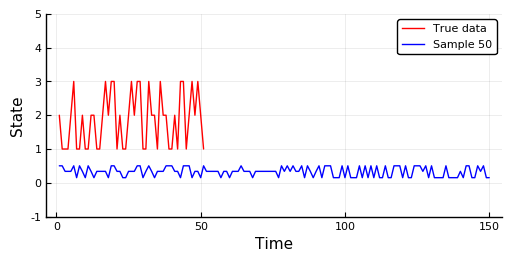

In [28]:
# Make an animation.
animation = @animate for i in 1:length(c)
    m = m_set[i, :]; 
    s = Int.(s_set[i,:]);
    emissions = collect(skipmissing(m[s]))
    
    p = plot(states, 
             color=:red,
             size = (500, 250),
             xlabel = "Time",
             ylabel = "State",
             legend = :topright, 
             label = "True data",
#              xlim = (0,15),
             ylim = (-1,5));
    plot!(emissions, color = :blue, label = "Sample $T")
end every 10;

In [7]:
# Index the chain with the persistence probabilities.
subchain = c[:,["T[$i][$i]" for i in 1:K],:]

Object of type Chains, with data of type 100×3×1 Array{Union{Missing, Real},3}

Iterations        = 1:100
Thinning interval = 1
Chains            = 1
Samples per chain = 100
parameters        = T[1][1], T[2][2], T[3][3]

2-element Array{ChainDataFrame,1}

Summary Statistics
. Omitted printing of 1 columns
│ Row │ parameters │ mean     │ std        │ naive_se    │ mcse    │ ess     │
│     │ Symbol     │ Float64  │ Float64    │ Float64     │ Missing │ Any     │
├─────┼────────────┼──────────┼────────────┼─────────────┼─────────┼─────────┤
│ 1   │ T[1][1]    │ 0.37684  │ 0.0102734  │ 0.00102734  │ missing │ 2.04082 │
│ 2   │ T[2][2]    │ 0.164554 │ 0.00359364 │ 0.000359364 │ missing │ 5.69015 │
│ 3   │ T[3][3]    │ 0.119931 │ 0.00743598 │ 0.000743598 │ missing │ 2.10215 │

Quantiles

│ Row │ parameters │ 2.5%     │ 25.0%    │ 50.0%    │ 75.0%    │ 97.5%    │
│     │ Symbol     │ Float64  │ Float64  │ Float64  │ Float64  │ Float64  │
├─────┼────────────┼──────────┼──────────┼──────────┼──

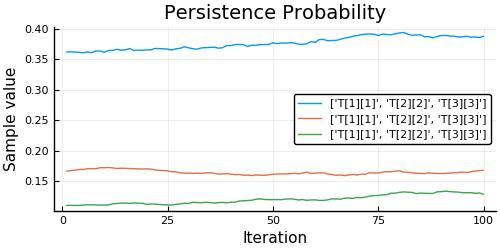

In [8]:
# Plot the chain.
plot(subchain, 
    colordim = :parameter, 
    seriestype=:traceplot,
    title = "Persistence Probability",
    legend=:right)

In [9]:
heideldiag(c[:T])

1-element Array{ChainDataFrame,1}

Heidelberger and Welch Diagnostic - Chain 1
. Omitted printing of 1 columns
│ Row │ parameters │ Burn-in │ Stationarity │ p-value │ Mean    │ Halfwidth │
│     │ Symbol     │ Float64 │ Float64      │ Float64 │ Float64 │ Float64   │
├─────┼────────────┼─────────┼──────────────┼─────────┼─────────┼───────────┤
│ 1   │ T[1][1]    │ 50.0    │ 0.0          │ 0.0471  │ 0.3839  │ 0.0074    │
│ 2   │ T[1][2]    │ 40.0    │ 1.0          │ 0.0636  │ 0.3723  │ 0.006     │
│ 3   │ T[1][3]    │ 30.0    │ 1.0          │ 0.1695  │ 0.2439  │ 0.0013    │
│ 4   │ T[2][1]    │ 10.0    │ 1.0          │ 0.0804  │ 0.75    │ 0.0031    │
│ 5   │ T[2][2]    │ 20.0    │ 1.0          │ 0.215   │ 0.1631  │ 0.0014    │
│ 6   │ T[2][3]    │ 0.0     │ 1.0          │ 0.5575  │ 0.0861  │ 0.0009    │
│ 7   │ T[3][1]    │ 0.0     │ 1.0          │ 0.063   │ 0.6713  │ 0.0087    │
│ 8   │ T[3][2]    │ 0.0     │ 1.0          │ 0.7609  │ 0.2088  │ 0.0022    │
│ 9   │ T[3][3]    │ 40.0    │ 